In [1]:
#Import lib
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from my_useful_functions import calculate_performance_statistical_parity,calculate_performance_equalized_odds,calculate_performance_equal_opportunity,calculate_performance_predictive_parity,calculate_performance_predictive_equality,calculate_performance_treatment_equality
from sklearn import preprocessing
from exponentiated_gradient_reduction import ExponentiatedGradientReduction
#import aif360.algorithms.inprocessing.ExponentiatedGradientReduction
from learning_fair_representations import LFR
from sklearn.base import BaseEstimator, ClassifierMixin
#Estimator
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from compute_abroca import *
import numpy as np
import sklearn.metrics as metrics 
from scipy import interpolate
from scipy import integrate
from disparate_impact_remover import DisparateImpactRemover
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[LawSchoolGPA]'
2023-03-10 20:02:41.369693: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 20:02:41.369707: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#http://archive.ics.uci.edu/ml/datasets/credit+approval
#http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html
#https://www.kaggle.com/code/chandanabhatt/prediction-of-credit-approval
# Credit approval dataset
# $ Male          : num  1 1 0 0 0 0 1 0 0 0 ...
# $ Age           : chr  "58.67" "24.50" "27.83" "20.17" ...
# $ Debt          : num  4.46 0.5 1.54 5.62 4 ...
# $ Married       : chr  "u" "u" "u" "u" ...
# $ BankCustomer  : chr  "g" "g" "g" "g" ...
# $ EducationLevel: chr  "q" "q" "w" "w" ...
# $ Ethnicity     : chr  "h" "h" "v" "v" ...
# $ YearsEmployed : num  3.04 1.5 3.75 1.71 2.5 ...
# $ PriorDefault  : num  1 1 1 1 1 1 1 1 1 0 ...
# $ Employed      : num  1 0 1 0 0 0 0 0 0 0 ...
# $ CreditScore   : num  6 0 5 0 0 0 0 0 0 0 ...
# $ DriversLicense: chr  "f" "f" "t" "f" ...
# $ Citizen       : chr  "g" "g" "g" "s" ...
# $ ZipCode       : chr  "00043" "00280" "00100" "00120" ...
# $ Income        : num  560 824 3 0 0 ...
# $ Approved      : chr  "+" "+" "+" "+" ...

def load_credit_approval():
    df = pd.read_csv('data/credit-approval.data',sep=",")
    protected_attribute = 'Male'
    majority_group_name = "Female"
    minority_group_name = "Male"
    class_label = 'Approved'
    filename = "LFR_Agar.credit_approval.abroca.png"
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    #Remove missing value
    df = df[df['Male'] != '?']   
    #Label sex
    df['Male']=["Female" if v == "a" else "Male" for v in df['Male']]
    #Label class
    df['Approved']=[1 if v == "+" else 0 for v in df['Approved']]
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df[class_label]
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X, y, sa_index, p_Group, protected_attribute, filename,majority_group_name,minority_group_name

In [3]:
#Credit card client
#Gender (1 = male; 2 = female)
def load_credit_card():
    df = pd.read_csv('data/credit-card-clients.csv')    
    protected_attribute = 'SEX'
    majority_group_name = "Male"
    minority_group_name = "Female"
    class_label = 'default payment'
    filename = "LFR_Agar.credit_card.abroca.png"   
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    
    #Label sex
    df['SEX']=["Female" if v == 2 else "Male" for v in df['SEX']]
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df[class_label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X, y,sa_index, p_Group, protected_attribute, filename,majority_group_name,minority_group_name

In [4]:
#German credit
def load_german_credit():
    df = pd.read_csv('data/german_data_credit.csv')    
    protected_attribute = 'sex'
    majority_group_name = "male"
    minority_group_name = "female"
    class_label = 'class-label'
    filename = "LFR_Agar.german_credit.abroca.png"    
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df[class_label]
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X, y,sa_index, p_Group, protected_attribute, filename,majority_group_name,minority_group_name

In [5]:
def load_PAKDD2010():
    df = pd.read_csv('data/PAKDD.csv')    
    protected_attribute = 'SEX'
    majority_group_name = "Male"
    minority_group_name = "Female"
    class_label = 'TARGET_LABEL_BAD'
    filename = "LFR_Agar.PAKDD.abroca.png"    
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    
    #Remove ID
    df=df.drop(columns=['ID_CLIENT'])
    df =df.dropna()
    df=df.drop(columns = ['RESIDENCIAL_PHONE_AREA_CODE','RESIDENCIAL_ZIP_3','PROFESSIONAL_ZIP_3'])
    #Label sex
    df['SEX']=["Female" if v == "F" else "Male" for v in df['SEX']]
    
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,:length-1]
    y = df[class_label]
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X, y,sa_index, p_Group, protected_attribute, filename,majority_group_name,minority_group_name

In [6]:
#Credit scoring data
#https://www.kaggle.com/code/islombekdavronov/credit-scoring
#FinTech companies in Central Asia.
def load_credit_scoring():
    df = pd.read_csv('data/credit_scoring.csv')    
    protected_attribute = 'Sex'
    majority_group_name = "Male"
    minority_group_name = "Female"
    class_label = 'label'
    filename = "LFR_Agar.credit_scoring.abroca.png"    
    
    print("Length:",len(df))
    print("Number of attribute:",len(df.columns))
    
    df = df.replace({'-':0})
    df['Score_point']=df['Score_point'].astype(float)
    
       
    #Label sex
    df['Sex']=["Female" if v == 2 else "Male" for v in df['Sex']]
    
    print("Length (cleaned):",len(df))
    print("Class imbalance: \n",df[class_label].value_counts())
    
    #label encode
    le = preprocessing.LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = le.fit_transform(df[i])
    #Splitting data into train and test
    length = len(df.columns)
    X = df.iloc[:,1:length-1]
    y = df[class_label]
    
    #Get index    
    feature = X.keys().tolist()    
    sa_index = feature.index(protected_attribute)
    p_Group = 0 
    
    return X, y,sa_index, p_Group, protected_attribute, filename,majority_group_name,minority_group_name

In [7]:
def run_experiment(X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name): 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)   
      
    dataset = BinaryLabelDataset(df=pd.concat([X, y.to_frame()], axis=1), label_names=[y.name], protected_attribute_names=[protected_attribute])
    datasetTrain = BinaryLabelDataset(df=pd.concat([X_train, y_train.to_frame()], axis=1), label_names=[y_train.name], protected_attribute_names=[protected_attribute])
    datasetTest = BinaryLabelDataset(df=pd.concat([X_test, y_test.to_frame()], axis=1), label_names=[y_test.name], protected_attribute_names=[protected_attribute])
    # Apply DisparateImpactRemover
    privileged_groups = [{protected_attribute: 1.0}]
    unprivileged_groups = [{protected_attribute: 0.0}]
    lfr = LFR(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
    dataset_train_transf = lfr.fit_transform(datasetTrain)
    dataset_test_transf = lfr.transform(datasetTest)
    
    # Convert the BinaryLabelDataset back to a pandas dataframe
    X_train_transf = dataset_train_transf.features
    y_train_transf = dataset_train_transf.labels.ravel()
    X_test_transf = dataset_test_transf.features
    y_test_transf= dataset_test_transf.labels.ravel()

    X_train_transf = pd.DataFrame(X_train_transf, columns = X_train.columns)
    y_train_transf = pd.Series(y_train_transf, name = y_train.name).astype(int)
    X_test_transf = pd.DataFrame(X_test_transf, columns = X_train.columns)
    y_test_transf = pd.Series(y_test_transf, name = y_train.name).astype(int)

    #Run DT model
    clf =  NB = GaussianNB()
    Reduction = ExponentiatedGradientReduction(prot_attr=protected_attribute,estimator=clf, constraints = "EqualizedOdds")
    Reduction.fit(X_train_transf,y_train_transf)
    y_predicts = Reduction.predict(X_test_transf)
    y_pred_probs = Reduction.predict_proba(X_test_transf)

    #Print measures
        
    print("Statistical parity:")
    print(calculate_performance_statistical_parity(X_test.values, y_test.values, y_predicts, sa_index, p_Group))
         
    print("Equal opportunity")
    print(calculate_performance_equal_opportunity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Equalized odds")
    print(calculate_performance_equalized_odds(X_test.values, y_test.values, y_predicts, y_pred_probs, sa_index, p_Group))
         
    print("Predictive parity")
    print(calculate_performance_predictive_parity(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Predictive equality")
    print(calculate_performance_predictive_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    print("Treatment equality")
    print(calculate_performance_treatment_equality(X_test.values, y_test.values, y_predicts,  sa_index, p_Group))
        
    
    #make predictions
    X_test['pred_proba'] = Reduction.predict_proba(X_test_transf)[:,1:2]
    X_test['true_label'] = y_test
    df_test = X_test
    
    print(len(df_test))
    #Compute Abroca
    slice = compute_abroca(df_test, pred_col = 'pred_proba' , label_col = 'true_label', protected_attr_col = protected_attribute,
                           majority_protected_attr_val = 1, n_grid = 10000,
                           plot_slices = True, majority_group_name=majority_group_name ,minority_group_name=minority_group_name,file_name = filename)
    print("ABROCA:",slice)
    plt.clf() 

In [8]:
#Main function
def run_eval(dataset):
    if dataset == 'credit-approval':
        X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_credit_approval()
        run_experiment(X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                        
    if dataset == 'credit-card':
        X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_credit_card()
        run_experiment(X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                        
    if dataset == 'german-credit':
        X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_german_credit()
        run_experiment(X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                            
    if dataset == 'PAKDD':
        X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_PAKDD2010()
        run_experiment(X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                                                
    if dataset == 'credit-scoring':
        X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name = load_credit_scoring()
        run_experiment(X, y,sa_index, p_Group,protected_attribute,filename,majority_group_name,minority_group_name)                                                                        
    

Length: 690
Number of attribute: 16
Length (cleaned): 678
Class imbalance: 
 0    374
1    304
Name: Approved, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.4411764705882353, 'f1-score': 0.6122448979591837, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.4411764705882353, 'f1-score': 0.6122448979591837, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.4411764705882353, 'f1-score': 0.6122448979591837, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.4411764705882353, 'f1-score': 0.6122448979591837, 'fairness': 0.060431654676258995, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.4411764

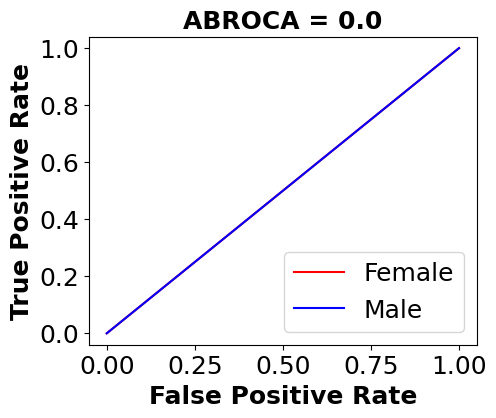

ABROCA: 0.0


<Figure size 640x480 with 0 Axes>

In [9]:
run_eval('credit-approval')

Length: 30000
Number of attribute: 24
Length (cleaned): 30000
Class imbalance: 
 0    23364
1     6636
Name: default payment, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.47183151669758816, 'accuracy': 0.46255555555555555, 'f1-score': 0.2835135535476226, 'fairness': -0.07250701078069383}
Equal opportunity
{'balanced_accuracy': 0.47183151669758816, 'accuracy': 0.46255555555555555, 'f1-score': 0.2835135535476226, 'fairness': 0.08442699073951226, 'TPR_protected': 0.5246636771300448, 'TPR_non_protected': 0.44023668639053254, 'TNR_protected': 0.42897261876901477, 'TNR_non_protected': 0.4962052764727141}
Equalized odds
{'balanced_accuracy': 0.47183151669758816, 'accuracy': 0.46255555555555555, 'f1-score': 0.2835135535476226, 'fairness': 0.15165964844321161, 'TPR_protected': 0.5246636771300448, 'TPR_non_protected': 0.44023668639053254, 'TNR_protected': 0.42897261876901477, 'TNR_non_protected': 0.4962052764727141}
Predictive parity
{'balanced_accuracy': 0.47183151669758816, 'accura

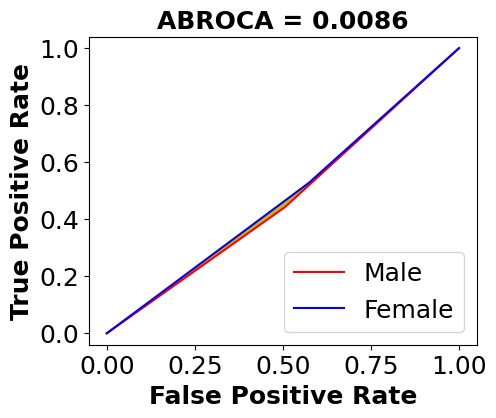

ABROCA: 0.008597167136125645


<Figure size 640x480 with 0 Axes>

In [10]:
run_eval('credit-card')

Length: 8755
Number of attribute: 18
Length (cleaned): 8755
Class imbalance: 
 1    8059
0     696
Name: label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.9128283212790255, 'f1-score': 0.9544278606965174, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.9128283212790255, 'f1-score': 0.9544278606965174, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.9128283212790255, 'f1-score': 0.9544278606965174, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.9128283212790255, 'f1-score': 0.9544278606965174, 'fairness': 0.031234142861573777, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.912828

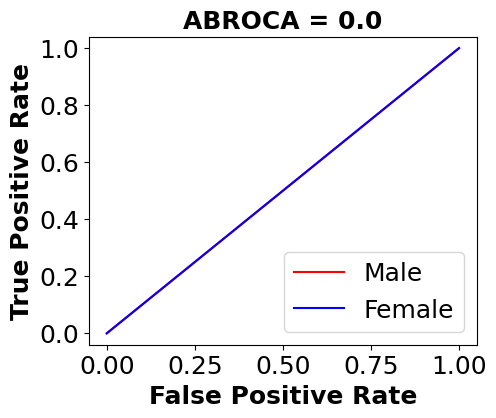

ABROCA: 0.0


<Figure size 640x480 with 0 Axes>

In [11]:
run_eval('credit-scoring')

Length: 1000
Number of attribute: 22
Length (cleaned): 1000
Class imbalance: 
 1    700
0    300
Name: class-label, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.0, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.6966666666666667, 'f1-score': 0.8212180746561886, 'fairness': 0.037092624356775294, 'TPR_protected': 1.0, 'TPR_non_protected': 1.0, 'TNR_protected': 0.0, 'TNR_non_protected': 0.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.69

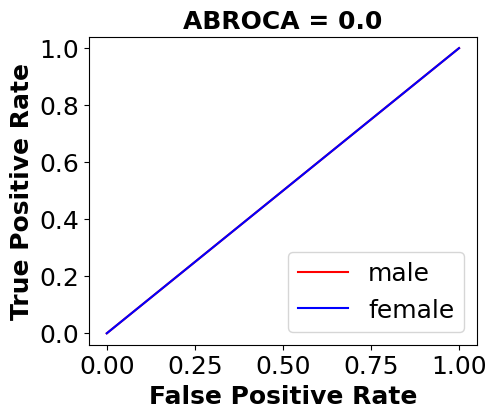

ABROCA: 0.0


<Figure size 640x480 with 0 Axes>

In [12]:
run_eval('german-credit')

Length: 50000
Number of attribute: 47
Length (cleaned): 38896
Class imbalance: 
 0    28747
1    10149
Name: TARGET_LABEL_BAD, dtype: int64
Statistical parity:
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0}
Equal opportunity
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Equalized odds
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive parity
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected': 0.0, 'TPR_non_protected': 0.0, 'TNR_protected': 1.0, 'TNR_non_protected': 1.0}
Predictive equality
{'balanced_accuracy': 0.5, 'accuracy': 0.7352815151255463, 'f1-score': 0.0, 'fairness': 0.0, 'TPR_protected':

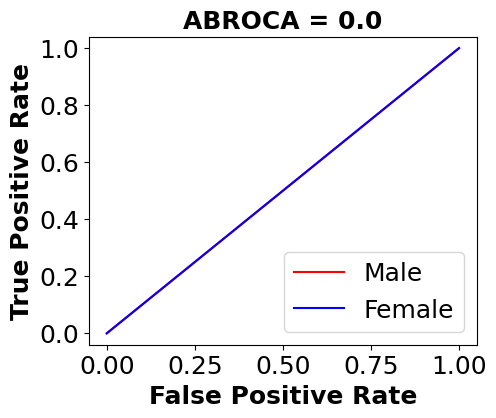

ABROCA: 0.0


<Figure size 640x480 with 0 Axes>

In [13]:
run_eval('PAKDD')